<a href="https://colab.research.google.com/github/smartaces/pinecone_ai_assistant_from_excel_csv_file_with_openai/blob/main/Shared_Ultimate_Custom_Dataset_Pinecone_Chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Create a Custom AI Chat Assistant with Excel, OpenAI and Pinecone**

This tool helps you create a custom AI chat solution using an excel csv file (or HuggingFace Dataset), OpenAI, and a Pinecone Vector Database (Free).

Full instructions on how to use this are provided below.

**Connect with Me**

If you like this notebook or in any way found it helpful, feel free to connect with me on LinkedIn here: https://www.linkedin.com/in/james-bentley-1b329214/

Also please like or share the accompanying YouTube video walkthrough:

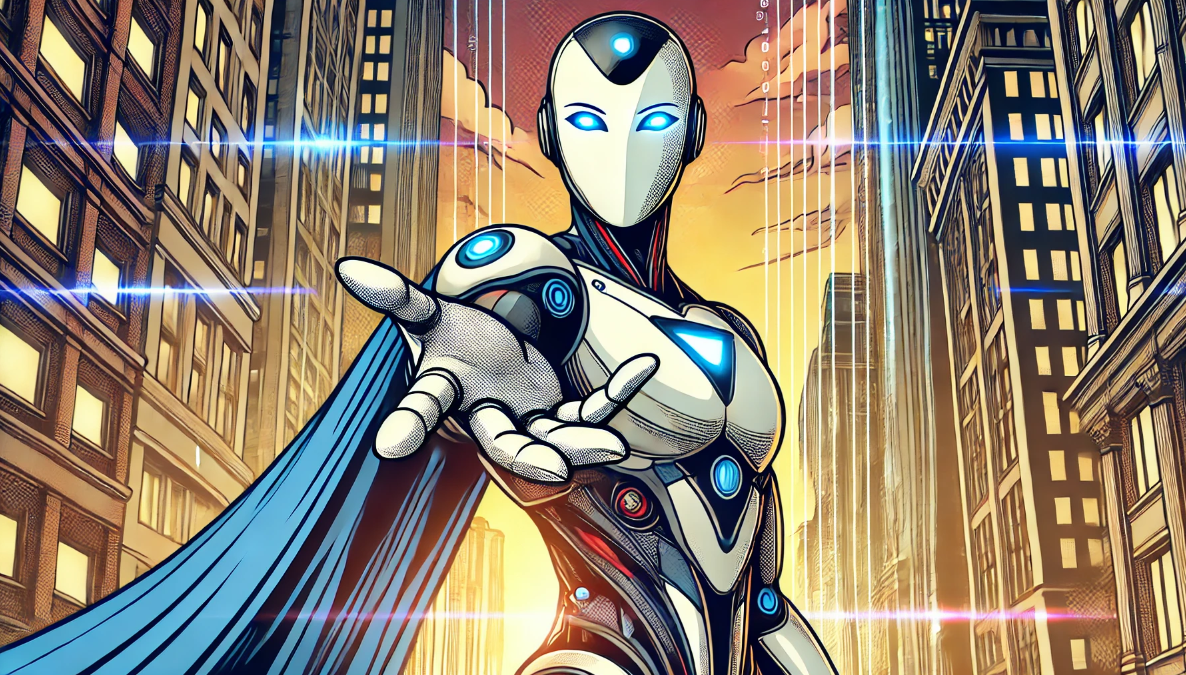

To use this notebook and build your solution you will need...

1.   An [OpenAI](https://https://openai.com/api/) user account and API Key (with billing set up)
2.   A [Pinecone](https://www.pinecone.io/) user account and API Key
3.   A [HuggingFace](https://huggingface.co/welcome) user account and API Key (optional)

Once you have all of these, add them to your Google Secrets (see the key icon on the left panel) inserting your key in the 'value' field and assigning the following names for each one respectively, and granting notebook access.

1. Name: openai_key
2. Name: PINECONE_API_KEY
3. Name: HF_TOKEN

Dataset Options:

Original Source Locations

* Tesco FAQ Dataset: https://www.kaggle.com/datasets/josephsueke/tesco-faq
* IMDB Top 1000 Dataset: https://www.kaggle.com/datasets/harshitshankhdhar/imdb-dataset-of-top-1000-movies-and-tv-shows

CSV File Versions

* Tesco FAQ Dataset: [CSV File Option](https://drive.google.com/file/d/1XKMCNot6naw9_sgQdEir9NR18uYsBUFb/view?usp=sharing)
* IMDB Top 100 Dataset: [CSV File Option](https://drive.google.com/file/d/1CBPR4-XJE6otbIeZ-5J_1vJqVkD2ZiPg/view?usp=sharing)


## **Part 1: Installs and API Key Setups**


We first need to setup our environment and retrieve API keys for OpenAI and Pinecone. Let's start with our environment, we need HuggingFace *Datasets* for our data, and the OpenAI and Pinecone clients:

In [ ]:
#installs
!pip install -qU \
    pinecone-client==3.0.2 \
    openai==1.10.0 \
    datasets==2.16.1
!pip install tiktoken --quiet
!pip install gradio -q
!pip install tqdm
!pip install -q datasets
!pip install -q -U bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.1/225.1 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.4/166.4 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requires 

In [ ]:
#setup and load your openai key
import os
from openai import OpenAI
from google.colab import userdata
from pinecone import Pinecone

# Retrieve the Pinecone API key from the user
PINECONE_API_KEY = userdata.get('PINECONE_API_KEY')

# Initialize Pinecone with the API key
pc = Pinecone(api_key=PINECONE_API_KEY)

print("Pinecone API key set up successfully!")

# Retrieve your OpenAI API key from Google Colab Secrets
openai_key = userdata.get('openai_key')

# Initialize the OpenAI client with your API key
client = OpenAI(api_key=openai_key)

print("OpenAI API key set up successfully!")

Pinecone API key set up successfully!
OpenAI API key set up successfully!


# **Part 2: Vectorising and Uploading a Dataset To Pinecone**

*(Skip this whole section if you already have a Pinecone index setup with data in it that you want to use the chat functionality with)*


In this section I take you through how to upload some data from either a csv file or from a HuggingFace dataset. As part of this we will...

1. Upload a csv file to Google drive, or access a HuggingFace Dataset
2. Check that data has populated information in each column (and removing any instances where it doesn't of necessary).
3. Select datafields for vectorising that will serve as the lookup keys in the vector database (Pinecone).
4. Select datafields to add as metadata for retrieval along with the key. This information is the stuff that will help the AI assistant answer user questions.
5. Select and assign and OpenAI embedding model to use for the embeddings.
6. Create a Pinecone index (database), with the correct dimensions to match the embedding model you are using, vectorise your data and insert it into the index - OR - load an existing Pinecone Index you may already have setup.
7. Run a few tests that everything is working.
8. Setup your AI Chat Assistant, selecting which information from the original dataset will be given to it to help answer user queries.
9. Load and run your chat assistant in a Gradio UI.  


**Load Dataset from CSV Option**

*(skip this if you want to load your data from HuggingFace - or already have some vectorised data in a Pinecone index you want to use)*

image.pngUse the folder icon on the left and the

image.png'upload to session storage option' to load and save a csv file to the temporary folder.

Then select from the drop down list option and hit the 'load dataset' button.  


In [ ]:
#load dataset from a csv file
import pandas as pd
from datasets import Dataset
import ipywidgets as widgets
from IPython.display import display
import os

# Initialize global variable in the global scope
DATASET = None

def get_csv_files():
    return [f for f in os.listdir('/content') if f.endswith('.csv')]

def load_global_dataset(file_name):
    global DATASET
    try:
        file_path = os.path.join('/content', file_name)
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"File '{file_name}' not found in /content/ folder")

        df = pd.read_csv(file_path)
        DATASET = Dataset.from_pandas(df)
        print(f"Dataset '{file_name}' loaded and set as global variable DATASET")
        print("\nDataset Info:")
        print(DATASET)
    except Exception as e:
        print(f"Error loading dataset '{file_name}': {str(e)}")
        DATASET = None

# Create dropdown widget for file selection
file_dropdown = widgets.Dropdown(
    options=get_csv_files(),
    description='Select CSV:',
    style={'description_width': 'initial'}
)

# Create a refresh button to update the file list
refresh_button = widgets.Button(
    description="Refresh File List",
    layout=widgets.Layout(width='150px')
)

load_button = widgets.Button(
    description="Load Dataset",
    layout=widgets.Layout(width='150px')
)

output = widgets.Output()

def on_refresh_button_click(b):
    file_dropdown.options = get_csv_files()

def on_load_button_click(b):
    with output:
        output.clear_output()
        if file_dropdown.value:
            load_global_dataset(file_dropdown.value)
        else:
            print("Please select a CSV file first.")

refresh_button.on_click(on_refresh_button_click)
load_button.on_click(on_load_button_click)

# Display widgets
display(widgets.VBox([
    file_dropdown,
    widgets.HBox([refresh_button, load_button]),
    output
]))

# Function to print current dataset info (can be used in other cells)
def print_current_dataset_info():
    global DATASET
    if DATASET is not None:
        print(f"Current global dataset: {DATASET}")
    else:
        print("No global dataset is currently set.")

# This line ensures the global variable is set in the notebook's global scope
get_ipython().run_cell_magic('capture', '', '%store DATASET')

**Load a HuggingFace Dataset**

*(Skip this if you are using the CSV method above, or if you already have some data in a Pinecone Index you want to use)*

In the box below add in the respective HuggingFace dataset profile name and dataset name e.g. JamesBentley/productfeedexample


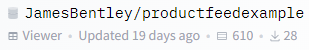

In [ ]:
#load dataset from huggingface
from datasets import load_dataset
import ipywidgets as widgets
from IPython.display import display

# Global variable to store the dataset
global DATASET
DATASET = None

def load_global_dataset(dataset_name, split='train'):
    global DATASET
    try:
        DATASET = load_dataset(dataset_name, split=split)
        print(f"Dataset '{dataset_name}' loaded and set as global variable DATASET")
        print("\nDataset Info:")
        print(DATASET)
    except Exception as e:
        print(f"Error loading dataset '{dataset_name}': {str(e)}")
        DATASET = None

# Create input widgets
dataset_input = widgets.Text(
    description="Dataset Name:",
    style={'description_width': 'initial'}
)
load_button = widgets.Button(
    description="Load Dataset",
    layout=widgets.Layout(width='60')  # This ensures the button text isn't cut off
)
output = widgets.Output()

def on_load_button_click(b):
    with output:
        output.clear_output()
        load_global_dataset(dataset_input.value)

load_button.on_click(on_load_button_click)

# Display widgets
display(widgets.VBox([
    dataset_input,
    load_button,
    output
]))

# Function to print current dataset info (can be used in other cells)
def print_current_dataset_info():
    global DATASET
    if DATASET is not None:
        print(f"Current global dataset: {DATASET}")
    else:
        print("No global dataset is currently set.")

# **Let's Check The Dataset By Printing The First Row**

(Do this whether you are loading from a csv or from a HuggingFace Dataset) *italicised text*

In [ ]:
#print a sample of the dataset to output to test it is working
DATASET[0]

{'ID': 1.0,
 'Topic': 'Online Grocery FAQs',
 'Subtopic': 'Delivery and collection basics',
 'Question': 'Where Tesco delivers to',
 'Answer': 'We deliver to most UK residential addresses. To check whether we deliver to your address, register your account, visit the grocery homepage, and book your delivery.\nIf for some reason, we’re unable to deliver to your address, you can still use our Click+Collect service.'}

## **Let's Print a Few Rows and Info About the Dataset**


In [ ]:
# Print a structured view of your dataset
if 'DATASET' not in globals() or DATASET is None:
    print("No dataset is currently loaded. Please load a dataset first.")
else:
    # Inspect dataset structure
    print("Dataset Info:")
    print(DATASET.info)

    print("\nDataset Features:")
    print(DATASET.features)

    print("\nNumber of items in dataset:")
    print(len(DATASET))

    print("\nFirst item in dataset:")
    print(DATASET[0])

    print("\nKeys in the first item:")
    print(DATASET[0].keys())

    print("\nSample of first 5 items:")
    for i in range(min(5, len(DATASET))):
        print(f"\nItem {i}:")
        print(DATASET[i])

    print("\nUnique keys across all items:")
    all_keys = set()
    for item in DATASET:
        all_keys.update(item.keys())
    print(all_keys)

    print("\nData types of values in the first item:")
    for key, value in DATASET[0].items():
        print(f"{key}: {type(value)}")

Dataset Info:
DatasetInfo(description='', citation='', homepage='', license='', features={'ID': Value(dtype='float64', id=None), 'Topic': Value(dtype='string', id=None), 'Subtopic': Value(dtype='string', id=None), 'Question': Value(dtype='string', id=None), 'Answer': Value(dtype='string', id=None)}, post_processed=None, supervised_keys=None, task_templates=None, builder_name=None, dataset_name=None, config_name=None, version=None, splits=None, download_checksums=None, download_size=None, post_processing_size=None, dataset_size=None, size_in_bytes=None)

Dataset Features:
{'ID': Value(dtype='float64', id=None), 'Topic': Value(dtype='string', id=None), 'Subtopic': Value(dtype='string', id=None), 'Question': Value(dtype='string', id=None), 'Answer': Value(dtype='string', id=None)}

Number of items in dataset:
97

First item in dataset:
{'ID': 1.0, 'Topic': 'Online Grocery FAQs', 'Subtopic': 'Delivery and collection basics', 'Question': 'Where Tesco delivers to', 'Answer': 'We deliver to m

## **Check and Clean Blank Rows From The Data**

This runs a check on the data columns in your csv file or huggingface data loaded in this sheet (so not the original source) and then removes rows where there is blank data in specific columns. Use the check boxes below to select which ones you want to remove. We do this to help ensure the AI assistant has the data it needs to properly answer user questions.

In [ ]:
import ipywidgets as widgets
from IPython.display import display, HTML

# Check if DATASET is defined
if 'DATASET' not in globals() or DATASET is None:
    print("No dataset is currently loaded. Please load a dataset first.")
else:
    # Get dataset features
    features = list(DATASET.features.keys())

    # Function to get a preview of the feature and count blank fields
    def get_feature_preview_and_blanks(feature):
        preview = str(DATASET[0][feature])[:50]  # Get first 50 characters
        preview_text = f"{preview}{'...' if len(str(DATASET[0][feature])) > 50 else ''}"

        # Count blank fields
        blank_count = sum(1 for item in DATASET if not item[feature])

        return preview_text, blank_count

    # Create widgets for each feature
    feature_widgets = []
    for feature in features:
        checkbox = widgets.Checkbox(value=False, description='', indent=False, layout=widgets.Layout(width='20px', margin='0 0 0 0'))
        preview, blank_count = get_feature_preview_and_blanks(feature)
        label = widgets.HTML(f"<p style='margin: 0; padding-left: 5px;'><strong>{feature}</strong> ({blank_count} blank): {preview}</p>")
        hbox = widgets.HBox([checkbox, label], layout=widgets.Layout(align_items='center'))
        feature_widgets.append(hbox)

    # Create a button to delete rows with blank fields
    delete_button = widgets.Button(
        description="Delete Rows with Blank Fields",
        button_style='danger',
        layout=widgets.Layout(width='250px', height='40px')
    )

    # Display feature widgets and button
    display(widgets.VBox(feature_widgets + [widgets.HBox([delete_button])]))

    # Function to handle delete button click
    def on_delete_button_clicked(b):
        global DATASET
        selected_features = [features[i] for i, widget in enumerate(feature_widgets) if widget.children[0].value]

        if not selected_features:
            print("No columns selected. Please select at least one column.")
            return

        initial_count = len(DATASET)

        # Filter out rows where any of the selected features are blank
        DATASET = DATASET.filter(lambda example: all(example[feature] for feature in selected_features))

        deleted_count = initial_count - len(DATASET)
        print(f"Deleted {deleted_count} rows with blank fields in the selected columns.")
        print(f"Dataset now has {len(DATASET)} rows.")

        # Update the blank counts in the display
        for i, feature in enumerate(features):
            _, blank_count = get_feature_preview_and_blanks(feature)
            feature_widgets[i].children[1].value = f"<p style='margin: 0; padding-left: 5px;'><strong>{feature}</strong> ({blank_count} blank): {get_feature_preview_and_blanks(feature)[0]}</p>"

    delete_button.on_click(on_delete_button_clicked)

## **Select Your Fields for The Prompt To Reference for Information Lookup**

So now we need to chose 1-3 columns which will be used as lookup key (of sorts) to cross reference the user's questions against, to find and retrieve the best fitting information to generate an answer from.

Ideally these columns will be quite short (3 to 15 words) and will contain a decent enough representation of what the user's query might be. If they are short this helps keep them specific enough to match to.  

So a good example might be a column with product names e.g. Samung S24 smartphone (if you were designing an AI assistant to recommend products). Or even better it might contain example user questions (which have the respective answers in an adjacent column).

Once you select these columns they will be combined into a single value and converted in vectors (numbers) to be inserted into your database (this will happen in a few steps).

In [ ]:
#select embedding fields - these create the lookup key for the semantic search
import ipywidgets as widgets
from IPython.display import display, HTML

# Check if DATASET is defined
if 'DATASET' not in globals() or DATASET is None:
    print("No dataset is currently loaded. Please load a dataset first.")
else:
    # Get dataset features
    features = list(DATASET.features.keys())

    # Function to get a preview of the feature
    def get_feature_preview(feature):
        preview = str(DATASET[0][feature])[:50]  # Get first 50 characters
        return f"{preview}{'...' if len(str(DATASET[0][feature])) > 50 else ''}"

    # Create widgets for each feature
    feature_widgets = []
    for feature in features:
        checkbox = widgets.Checkbox(value=False, description='', indent=False, layout=widgets.Layout(width='20px', margin='0 0 0 0'))
        preview = get_feature_preview(feature)
        label = widgets.HTML(f"<p style='margin: 0; padding-left: 5px;'><strong>{feature}</strong>: {preview}</p>")
        hbox = widgets.HBox([checkbox, label], layout=widgets.Layout(align_items='center'))
        feature_widgets.append(hbox)

    # Create a larger button to confirm selection
    confirm_embed_button = widgets.Button(
        description="Confirm Embedding Fields",
        button_style='info',
        layout=widgets.Layout(width='250px', height='40px')
    )

    # Display feature widgets and button
    display(widgets.VBox(feature_widgets + [widgets.HBox([confirm_embed_button])]))

    # Function to handle button click
    def on_embed_button_clicked(b):
        global embedding_fields
        embedding_fields = [features[i] for i, widget in enumerate(feature_widgets) if widget.children[0].value]
        print("Selected embedding fields:", embedding_fields)

    confirm_embed_button.on_click(on_embed_button_clicked)

Selected embedding fields: ['Subtopic', 'Question']


## **Select The Information To Give To The Assistant To Inform The Response It Generates**

In the above step, we selected our lookup/ reference key. Now we need to select from our dataset, which information the AI assistant will use in its response generation.

So this can include the values that included in the lookup key step above, ideally though it will include a larger body of text/ information - maybe a paragraph of 5 or so lines (it can be longer, but longer texts cost more to process). It can also include links to webpages/ images (if they are provided as a column in your dataset)

Good examples include...

*   If you were designing a product recommendation assistant, you might include the product description or promotional text, a web link to the product, or a link to an image of the product, or the product price.

*   A paragraph of text with an answer to a frequently asked question, and link to the original source webpage.





In [ ]:
import ipywidgets as widgets
from IPython.display import display, HTML

# Check if DATASET is defined
if 'DATASET' not in globals() or DATASET is None:
    print("No dataset is currently loaded. Please load a dataset first.")
else:
    # Get dataset features
    features = list(DATASET.features.keys())

    # Function to get a preview of the feature
    def get_feature_preview(feature):
        preview = str(DATASET[0][feature])[:50]  # Get first 50 characters
        return f"{preview}{'...' if len(str(DATASET[0][feature])) > 50 else ''}"

    # Create widgets for each feature
    feature_widgets = []
    for feature in features:
        checkbox = widgets.Checkbox(value=True, description='', indent=False, layout=widgets.Layout(width='20px', margin='0 0 0 0'))
        preview = get_feature_preview(feature)
        label = widgets.HTML(f"<p style='margin: 0; padding-left: 5px;'><strong>{feature}</strong>: {preview}</p>")
        hbox = widgets.HBox([checkbox, label], layout=widgets.Layout(align_items='center'))
        feature_widgets.append(hbox)

    # Create a larger button to confirm selection
    confirm_button = widgets.Button(
        description="Confirm Metadata Fields",
        button_style='info',
        layout=widgets.Layout(width='250px', height='40px')
    )

    # Display feature widgets and button
    display(widgets.VBox(feature_widgets + [widgets.HBox([confirm_button])]))

    # Function to handle button click
    def on_button_clicked(b):
        global metadata_fields
        metadata_fields = [features[i] for i, widget in enumerate(feature_widgets) if widget.children[0].value]
        print("Selected metadata fields:", metadata_fields)

    confirm_button.on_click(on_button_clicked)

Selected metadata fields: ['Topic', 'Subtopic', 'Question', 'Answer']


### **Choose The Model To Embed our Selected Datasets**

Now we have selected the data we want to use for the lookup key, and information the AI assistant will generate it's response from, we need to choose an AI model to convert these bits of information to numbers, which will subsequently be uploaded to the vector database Pinecone.

There are three option (all of them OpenAI models).

Which one you use is up to you, I recommend researching each one. The main point to look out for is that they generate embeddings of different sizes (3072 or 1536). 3072 is more expensive than 1536, and slightly more precise (in some ways).  

This has implications for a setting in your Pinecone database, but I have designed this notebook to automatically pick the right setting for you.

If you are in any doubt I recommend using text-embedding-3-small.

Pick the model from the drop down list, then hit confirm selection to proceed.

In [ ]:
#embedding model selection
import ipywidgets as widgets
from IPython.display import display, HTML

# Global variables to store the selected model and dimensions
EMBED_MODEL = None
DIMENSIONS = None

class AIModelSelector:
    def __init__(self):
        self.model_info = {
            'text-embedding-3-large': {
                'description': 'Most capable embedding model for both english and non-english tasks',
                'dimensions': 3072,
                'provider': 'OpenAI'
            },
            'text-embedding-3-small': {
                'description': 'Increased performance over 2nd generation ada embedding model',
                'dimensions': 1536,
                'provider': 'OpenAI'
            },
            'text-embedding-ada-002': {
                'description': 'Most capable 2nd generation embedding model, replacing 16 first generation models',
                'dimensions': 1536,
                'provider': 'OpenAI'
            }
        }

        self.create_widgets()

    def create_widgets(self):
        # Create the dropdown
        self.model_dropdown = widgets.Dropdown(
            options=list(self.model_info.keys()),
            description='Select Model:',
            disabled=False,
        )

        # Create the table
        table_html = '''
        <table border="1">
          <tr>
            <th>Model Name</th>
            <th>Description</th>
            <th>Dimensions</th>
            <th>Provider</th>
          </tr>
        '''
        for model, info in self.model_info.items():
            table_html += f'''
            <tr>
              <td>{model}</td>
              <td>{info['description']}</td>
              <td>{info['dimensions']}</td>
              <td>{info['provider']}</td>
            </tr>
            '''
        table_html += '</table>'

        self.table_widget = widgets.HTML(value=table_html)

        # Create labels to display selected values
        self.model_label = widgets.Label(value="Selected Model: ")
        self.dimensions_label = widgets.Label(value="Dimensions: ")

        # Create confirmation button
        self.confirm_button = widgets.Button(description="Confirm Selection")
        self.confirm_button.on_click(self.confirm_selection)

        # Create output widget for confirmation message
        self.output = widgets.Output()

        # Set up the layout
        self.layout = widgets.VBox([
            self.model_dropdown,
            self.table_widget,
            self.model_label,
            self.dimensions_label,
            self.confirm_button,
            self.output
        ])

        # Set up the observer for dropdown changes
        self.model_dropdown.observe(self.update_selection, names='value')

    def update_selection(self, change):
        global EMBED_MODEL, DIMENSIONS
        EMBED_MODEL = change.new
        DIMENSIONS = self.model_info[EMBED_MODEL]['dimensions']

        self.model_label.value = f"Selected Model: {EMBED_MODEL}"
        self.dimensions_label.value = f"Dimensions: {DIMENSIONS}"

    def confirm_selection(self, b):
        with self.output:
            self.output.clear_output()
            print(f"Model selected: {EMBED_MODEL}")
            print(f"Dimensions set as: {DIMENSIONS}")

    def display(self):
        display(self.layout)

# Create and display the selector
selector = AIModelSelector()
selector.display()

# Function to print current selection (can be used in other cells)
def print_current_selection():
    print(f"Currently selected model: {EMBED_MODEL}")
    print(f"Dimensions: {DIMENSIONS}")

### **Create Your Pinecone Index (Optional)**

*(Only Skip This Step If You Already Have A Pinecone Index Setup With The Correct Embedding Size Setting e.g. 3072 or 1536)*

So now you have picked your data, chosen your embedding model.

Next up you need to create your database (index) in Pinecone.

Make sure you have created your Pinecone account and  API key.

Add your API key into the Key folder (to the left) in this notebook, and name it PINECONE_API_KEY.

You will need to grant the notebook access to use it. (This is private to you).

Then in the field below, give your index (database) a name, and the rest of the settings will be automatically applied.

If successful you should see the following response 'index 'YOURINDEXNAME' created successfully!.

If you login to Pinecone you should also see it set up.

In [ ]:
#create Pinecone index if one doesn't already exist
import time
import re
from pinecone import ServerlessSpec
import ipywidgets as widgets
from IPython.display import display, HTML

# Global variable for index name
INDEX_NAME = None

def create_index(index_name):
    global INDEX_NAME
    # Validate index name
    if not re.match(r'^[a-z0-9-]+$', index_name):
        print("Error: Index name can only contain lowercase letters, numbers, and hyphens.")
        return

    spec = ServerlessSpec(cloud="aws", region="us-east-1")

    # Check if index already exists
    if index_name not in pc.list_indexes().names():
        # If it does not exist, create index
        pc.create_index(
            index_name,
            dimension=DIMENSIONS,  # dimensionality from the selected embedding model
            metric='cosine',
            spec=spec
        )
        print(f"Creating index '{index_name}'...")
        # Wait for index to be initialized
        while not pc.describe_index(index_name).status['ready']:
            time.sleep(1)
        print(f"Index '{index_name}' created successfully!")
    else:
        print(f"Index '{index_name}' already exists.")

    # Set the global INDEX_NAME
    INDEX_NAME = index_name

    # Connect to index
    index = pc.Index(index_name)
    time.sleep(1)

    # View index stats
    print("\nIndex stats:")
    print(index.describe_index_stats())

# Create input widget
index_name_input = widgets.Text(description="Index Name:")
create_button = widgets.Button(description="Create Index")

# Create info display
info_display = widgets.HTML(
    value=f"""
    <b>Pre-set Information:</b><br>
    Dimensions: {DIMENSIONS}<br>
    Cloud: AWS<br>
    Region: us-east-1
    """
)

def on_create_button_click(b):
    create_index(index_name_input.value)

create_button.on_click(on_create_button_click)

# Display widgets
display(index_name_input, info_display, create_button)

# Function to print current index name (can be used in other cells)
def print_current_index():
    print(f"Current index name: {INDEX_NAME}")

Text(value='', description='Index Name:')

HTML(value='\n    <b>Pre-set Information:</b><br>\n    Dimensions: 3072<br>\n    Cloud: AWS<br>\n    Region: u…

Button(description='Create Index', style=ButtonStyle())

Creating index 'demo'...
Index 'demo' created successfully!

Index stats:
{'dimension': 3072,
 'index_fullness': 0.0,
 'namespaces': {},
 'total_vector_count': 0}


### **Load A Pre-Existing  Pinecone Index (Optional)**

*(Only Do This Step If You Already Have A Pinecone Index Setup With The Correct Embedding Size Setting e.g. 3072 or 1536)*

If you already have a Pinecone Index you can connect to it using this code. The Index must have been setup with the correct embedding size relative to your embedding model. And you should be using one of the OpenAI embedding models listed above.

In [ ]:
#load existing index (if you have already created one)
import ipywidgets as widgets
from IPython.display import display

# Ensure INDEX_NAME is declared as a global variable
global INDEX_NAME
if 'INDEX_NAME' not in globals():
    INDEX_NAME = None

def load_index(index_name):
    global INDEX_NAME
    try:
        index = pc.Index(index_name)
        print(f"Successfully loaded index '{index_name}'")
        print("\nIndex stats:")
        print(index.describe_index_stats())

        # Set the global INDEX_NAME after successful API response
        INDEX_NAME = index_name
        print(f"Global INDEX_NAME set to: {INDEX_NAME}")

    except Exception as e:
        print(f"Error: Failed to load index '{index_name}'. {str(e)}")

# Create input widget
load_index_input = widgets.Text(description="Index Name:")
load_button = widgets.Button(description="Load Index")

def on_load_button_click(b):
    load_index(load_index_input.value)

load_button.on_click(on_load_button_click)

# Display widgets
display(load_index_input, load_button)

# Function to print current index name (can be used in other cells)
def print_current_index():
    print(f"Current index name: {INDEX_NAME}")

### **Test Your Pinecone Index Connection**

Whether you created a brand new Pinecone Index above, or loaded a pre-existing one, you can check your connection using this code. Simply insert the name of your index and hit connect. This will confirm that everything is working properly.

In [ ]:
#check connection
from pinecone import Pinecone
from google.colab import userdata
import ipywidgets as widgets
from IPython.display import display

# Ensure INDEX_NAME is declared as a global variable
global INDEX_NAME
if 'INDEX_NAME' not in globals():
    INDEX_NAME = None

# Retrieve the Pinecone API key from the user
PINECONE_API_KEY = userdata.get('PINECONE_API_KEY')

def connect_to_pinecone(index_name):
    global INDEX_NAME
    try:
        pc = Pinecone(api_key=PINECONE_API_KEY)
        index = pc.Index(index_name)

        # Perform an operation to ensure the connection is established
        index_stats = index.describe_index_stats()
        print(f"Successfully connected to Pinecone index '{index_name}'!")
        print("Index Stats:", index_stats)

        # Update the global INDEX_NAME
        INDEX_NAME = index_name
        print(f"Global INDEX_NAME updated to: {INDEX_NAME}")

    except Exception as e:
        print(f"Failed to connect to Pinecone index '{index_name}':", str(e))

# Create input widget for index name
index_name_input = widgets.Text(description="Index Name:")
connect_button = widgets.Button(description="Connect to Index")

def on_connect_button_click(b):
    connect_to_pinecone(index_name_input.value)

connect_button.on_click(on_connect_button_click)

# Display widgets
display(index_name_input, connect_button)

# Function to print current index name (can be used in other cells)
def print_current_index():
    print(f"Current index name: {INDEX_NAME}")

Text(value='', description='Index Name:')

Button(description='Connect to Index', style=ButtonStyle())

Successfully connected to Pinecone index 'demo'!
Index Stats: {'dimension': 3072,
 'index_fullness': 0.0,
 'namespaces': {},
 'total_vector_count': 0}
Global INDEX_NAME updated to: demo


In [ ]:
#double check your index if you need to
print(f"Current index name: {INDEX_NAME}")

Current index name: demo


### **Upload Your Selected Data To Pinecone (Optional)**

Ok so, if you created a new Pinecone Index above, then you now need to embed and upload the data you selected. To do this simply run this cell. If everything is working fine, you will see a progress bar load and the job will complete.

Congrats - you now have your vector database and data set up.

In [ ]:
#upload the data to pinecone
from openai import OpenAI
from google.colab import userdata
from pinecone import Pinecone
from tqdm import tqdm

# Check if required global variables are set
if 'DATASET' not in globals() or DATASET is None:
    raise ValueError("DATASET is not set. Please load a dataset first.")
if 'EMBED_MODEL' not in globals() or EMBED_MODEL is None:
    raise ValueError("EMBED_MODEL is not set. Please select an embedding model first.")
if 'INDEX_NAME' not in globals() or INDEX_NAME is None:
    raise ValueError("INDEX_NAME is not set. Please create or select an index first.")

# Retrieve your OpenAI API key from Google Colab Secrets
openai_key = userdata.get('openai_key')

# Initialize the OpenAI client with your API key
client = OpenAI(api_key=openai_key)

# Retrieve the Pinecone API key and initialize
pc = Pinecone(api_key=userdata.get('PINECONE_API_KEY'))
index = pc.Index(INDEX_NAME)

# Function to get embeddings
def get_embedding(text, model=EMBED_MODEL):
    response = client.embeddings.create(input=text, model=model)
    return response.data[0].embedding

# Function to handle null values in metadata
def clean_metadata(metadata):
    return {k: v if v is not None else "" for k, v in metadata.items()}

# Process and upload data
for i, item in enumerate(tqdm(DATASET)):
    # Combine relevant fields for embedding
    text_to_embed = " ".join([item[field] or "" for field in embedding_fields]).strip()

    if not text_to_embed:
        print(f"Empty text to embed at index {i}")
        continue

    # Get embedding
    embedding = get_embedding(text_to_embed)

    # Prepare metadata (including selected fields)
    metadata = clean_metadata({field: item[field] for field in metadata_fields})

    try:
        # Upsert to Pinecone
        index.upsert(vectors=[(f'item-{i}', embedding, metadata)])
    except Exception as e:
        print(f"Error upserting item {i}: {str(e)}")
        print(f"Problematic metadata: {metadata}")

print("Dataset upload process completed!")

# View index stats
print(f"Stats for index '{INDEX_NAME}':")
print(index.describe_index_stats())

100%|██████████| 97/97 [00:35<00:00,  2.75it/s]

Dataset upload process completed!
Stats for index 'demo':
{'dimension': 3072,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 96}},
 'total_vector_count': 96}


### **AI Assistant Setup**

Ok so now for the fun part, powering up our AI assistant. Before we jump into this, it's worthwhile running a quick check to ensure your database is setup, and your embedding model is correctly selected.

Run the below cell to confirm this.

In [ ]:
#check if you have an index connected already?
# If an index is already set, display its information
if INDEX_NAME is not None:
    print(f"Using existing index: {INDEX_NAME}")
    try:
        index = pc.Index(INDEX_NAME)
        print("Index stats:")
        print(index.describe_index_stats())
    except Exception as e:
        print(f"Error accessing existing index: {str(e)}")
        INDEX_NAME = None
print(f"Current Embedding Model: {EMBED_MODEL}")
print(f"Current Embedding Model: {DIMENSIONS}")

Using existing index: demo
Index stats:
{'dimension': 3072,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 98}},
 'total_vector_count': 98}
Current Embedding Model: text-embedding-3-large
Current Embedding Model: 3072


### **What If an Error Shows for My Index Name? (Optional)**

If you followed the above steps this shouldn't happen, and you can skip ahead.

If for some reason you see an error, run the below cell, input your Index Name. This will ensure it is setup and assigned properly.


In [ ]:
#Assign Index Name if None Assigned
from pinecone import Pinecone
from google.colab import userdata
import ipywidgets as widgets
from IPython.display import display

# Retrieve the Pinecone API key and initialize
PINECONE_API_KEY = userdata.get('PINECONE_API_KEY')
pc = Pinecone(api_key=PINECONE_API_KEY)

# Ensure INDEX_NAME is declared as a global variable
global INDEX_NAME
if 'INDEX_NAME' not in globals():
    INDEX_NAME = None

def load_index(index_name):
    global INDEX_NAME
    try:
        index = pc.Index(index_name)
        print(f"Successfully loaded index '{index_name}'")
        print("\nIndex stats:")
        print(index.describe_index_stats())

        # Set the global INDEX_NAME after successful API response
        INDEX_NAME = index_name
        print(f"Global INDEX_NAME set to: {INDEX_NAME}")

    except Exception as e:
        print(f"Error: Failed to load index '{index_name}'. {str(e)}")

# Create input widget for index name
index_name_input = widgets.Text(description="Index Name:")
load_button = widgets.Button(description="Load Index")
output = widgets.Output()

def on_load_button_click(b):
    with output:
        output.clear_output()
        load_index(index_name_input.value.strip())

load_button.on_click(on_load_button_click)

# Display widgets
display(widgets.VBox([index_name_input, load_button, output]))

# Function to get current index name (can be used in other cells)
def get_current_index_name():
    if INDEX_NAME is not None:
        return INDEX_NAME
    else:
        print("No index is currently set. Please load an index first.")
        return None

# If an index is already set, display its information
if INDEX_NAME is not None:
    print(f"Using existing index: {INDEX_NAME}")
    try:
        index = pc.Index(INDEX_NAME)
        print("Index stats:")
        print(index.describe_index_stats())
    except Exception as e:
        print(f"Error accessing existing index: {str(e)}")
        INDEX_NAME = None

### **What If an Error Shows for My Embedding Model Name? (Optional)**

If you followed the above steps this shouldn't happen, and you can skip ahead.

If for some reason you see an error, run the below cell, select your Embedding Model. This will ensure it is setup and assigned properly.

In [ ]:
#Assign an embedding model if you skipped any of the earlier steps
import ipywidgets as widgets
from IPython.display import display, HTML

# Global variables to store the selected model and dimensions
EMBED_MODEL = None
DIMENSIONS = None

class AIModelSelector:
    def __init__(self):
        self.model_info = {
            'text-embedding-3-large': {
                'description': 'Most capable embedding model for both english and non-english tasks',
                'dimensions': 3072,
                'provider': 'OpenAI'
            },
            'text-embedding-3-small': {
                'description': 'Increased performance over 2nd generation ada embedding model',
                'dimensions': 1536,
                'provider': 'OpenAI'
            },
            'text-embedding-ada-002': {
                'description': 'Most capable 2nd generation embedding model, replacing 16 first generation models',
                'dimensions': 1536,
                'provider': 'OpenAI'
            }
        }

        self.create_widgets()

    def create_widgets(self):
        # Create the dropdown
        self.model_dropdown = widgets.Dropdown(
            options=list(self.model_info.keys()),
            description='Select Model:',
            disabled=False,
        )

        # Create the table
        table_html = '''
        <table border="1">
          <tr>
            <th>Model Name</th>
            <th>Description</th>
            <th>Dimensions</th>
            <th>Provider</th>
          </tr>
        '''
        for model, info in self.model_info.items():
            table_html += f'''
            <tr>
              <td>{model}</td>
              <td>{info['description']}</td>
              <td>{info['dimensions']}</td>
              <td>{info['provider']}</td>
            </tr>
            '''
        table_html += '</table>'

        self.table_widget = widgets.HTML(value=table_html)

        # Create labels to display selected values
        self.model_label = widgets.Label(value="Selected Model: ")
        self.dimensions_label = widgets.Label(value="Dimensions: ")

        # Create confirmation button
        self.confirm_button = widgets.Button(description="Confirm Selection")
        self.confirm_button.on_click(self.confirm_selection)

        # Create output widget for confirmation message
        self.output = widgets.Output()

        # Set up the layout
        self.layout = widgets.VBox([
            self.model_dropdown,
            self.table_widget,
            self.model_label,
            self.dimensions_label,
            self.confirm_button,
            self.output
        ])

        # Set up the observer for dropdown changes
        self.model_dropdown.observe(self.update_selection, names='value')

    def update_selection(self, change):
        global EMBED_MODEL, DIMENSIONS
        EMBED_MODEL = change.new
        DIMENSIONS = self.model_info[EMBED_MODEL]['dimensions']

        self.model_label.value = f"Selected Model: {EMBED_MODEL}"
        self.dimensions_label.value = f"Dimensions: {DIMENSIONS}"

    def confirm_selection(self, b):
        with self.output:
            self.output.clear_output()
            print(f"Model selected: {EMBED_MODEL}")
            print(f"Dimensions set as: {DIMENSIONS}")

    def display(self):
        display(self.layout)

# Create and display the selector
selector = AIModelSelector()
selector.display()

# Function to print current selection (can be used in other cells)
def print_current_selection():
    print(f"Currently selected model: {EMBED_MODEL}")
    print(f"Dimensions: {DIMENSIONS}")

### **Simple Test Of AI Assistant**

Before we load our AI Assistant in full we can quickly check whether the fundamentals are working as they should.

You can use the below code to insert a test prompt.

Add it in the below speech marks, and then hit the cell run button.

query = "INSERT YOUR PROMPT HERE"



In [ ]:
from openai import OpenAI
from google.colab import userdata

# Check if EMBED_MODEL is defined
if 'EMBED_MODEL' not in globals() or EMBED_MODEL is None:
    raise ValueError("EMBED_MODEL is not set. Please select an embedding model first.")

# Function to vectorize a query
def vectorize_query(query):
    try:
        xq = client.embeddings.create(input=query, model=EMBED_MODEL).data[0].embedding
        print(f"Query vectorized using model: {EMBED_MODEL}")
        return xq
    except Exception as e:
        print(f"Error vectorizing query: {str(e)}")
        return None

# Example usage
query = "can i choose my delivery times?"
xq = vectorize_query(query)

if xq is not None:
    print(f"Query vectorized successfully. Vector dimension: {len(xq)}")
else:
    print("Failed to vectorize query.")

# Function to vectorize a query (can be used in other cells)
def get_query_vector(query):
    return vectorize_query(query)

Query vectorized using model: text-embedding-3-large
Query vectorized successfully. Vector dimension: 3072


### **Now Check The Response**

You can now see what kind of a result matches back to the prompt, to get a sense of whether the lookup matching is working well.

The below code only returns the single top result.

You can return more if you wish by modifying top_k=1, though I wouldn't recommend going above 5 for this.

In [ ]:
#check the test output - this is an uncleaned raw output

res = index.query(vector=[xq], top_k=1, include_metadata=True)
res

{'matches': [{'id': 'item-4',
              'metadata': {'Answer': 'You can choose to get your shopping '
                                     'delivered between 8am-11pm Monday to '
                                     'Friday and 8am-10pm on Saturday and '
                                     'Sunday. In some stores, we offer 6am or '
                                     '7am slots.\n'
                                     'Visit the\xa0book a slot page\xa0to see '
                                     'slots available in your area.\n'
                                     'Delivery and collection options:\n'
                                     'Delivery – standard, next day and beyond '
                                     'have a slot length of 1-2 hours\n'
                                     'Standard home deliveries are available 7 '
                                     'days a week\n'
                                     'Flexi saver – next day and beyond have a '
               

### **Set The Context Your AI Assistant Uses For Responses**

So this is the last step before powering up the AI Assistant.

Use the below selection boxes to select what information, the CONTEXT, you want the Assistant to be given to inform their responses.

You can also select a link to give to the AI Assistant to pass on to the user

What this effectively does is...

When a user asks a question, you are determining that the AI assistant will be given specific types of information from your dataset to answer the question, for example...

**Context Fields**

*   If you were designing a product recommendation assistant, you might include the product description or promotional text
*   A paragraph of text with an answer to a frequently asked question


**Link Fields**

*   A original source webpage.
*   Link to a product page which contains more information

In [ ]:
import ipywidgets as widgets
from IPython.display import display
from pinecone import Pinecone
from google.colab import userdata

# Check if required global variables are set
if 'INDEX_NAME' not in globals() or INDEX_NAME is None:
    raise ValueError("INDEX_NAME is not set. Please set the index name first.")

if 'EMBED_MODEL' not in globals() or EMBED_MODEL is None:
    raise ValueError("EMBED_MODEL is not set. Please select an embedding model first.")

# Initialize Pinecone client
PINECONE_API_KEY = userdata.get('PINECONE_API_KEY')
pc = Pinecone(api_key=PINECONE_API_KEY)

# Initialize Pinecone index
index = pc.Index(INDEX_NAME)

# Get the dimension of the index
index_stats = index.describe_index_stats()
vector_dim = index_stats['dimension']
print(f"Index dimension: {vector_dim}")

# Fetch a sample vector to get metadata fields
sample_result = index.query(vector=[0]*vector_dim, top_k=1, include_metadata=True)
if not sample_result['matches']:
    raise ValueError("Unable to fetch sample data from the index. Please check if the index is empty.")

metadata_fields = list(sample_result['matches'][0]['metadata'].keys())

# Initialize global variables for metadata field configuration
global CONTEXT_FIELDS, LINK_FIELDS
CONTEXT_FIELDS = []
LINK_FIELDS = []

# Create widgets
context_checkboxes = [widgets.Checkbox(description=field, value=False) for field in metadata_fields]
link_checkboxes = [widgets.Checkbox(description=field, value=False) for field in metadata_fields]

context_box = widgets.VBox([widgets.Label('Select Context Fields:')] + context_checkboxes)
link_box = widgets.VBox([widgets.Label('Select Link Fields:')] + link_checkboxes)

def update_fields(b):
    global CONTEXT_FIELDS, LINK_FIELDS
    CONTEXT_FIELDS = [cb.description for cb in context_checkboxes if cb.value]
    LINK_FIELDS = [cb.description for cb in link_checkboxes if cb.value]
    print(f"Context fields updated to: {CONTEXT_FIELDS}")
    print(f"Link fields updated to: {LINK_FIELDS}")

update_button = widgets.Button(description="Update Fields")
update_button.on_click(update_fields)

# Display widgets
display(widgets.HBox([context_box, link_box]), update_button)

# Function to get current field selections (can be used in other cells)
def get_field_selections():
    global CONTEXT_FIELDS, LINK_FIELDS
    return {
        "CONTEXT_FIELDS": CONTEXT_FIELDS,
        "LINK_FIELDS": LINK_FIELDS
    }

Index dimension: 3072


Button(description='Update Fields', style=ButtonStyle())

Context fields updated to: ['Answer']
Link fields updated to: []


### **Power Up The AI Assistant**

The below code powers up the AI assistant in a chat interface. You can either run it in the below cell output display, or you can click one of the available links to open it in a dedicated webpage.

Congratulations, you now have an AI Assistant :)

In [ ]:
#chatbot initialised with field selections - needs debugging
import gradio as gr
from openai import OpenAI
from pinecone import Pinecone
from google.colab import userdata

# Check if required global variables are set
if 'EMBED_MODEL' not in globals() or EMBED_MODEL is None:
    raise ValueError("EMBED_MODEL is not set. Please select an embedding model first.")
if 'INDEX_NAME' not in globals() or INDEX_NAME is None:
    raise ValueError("INDEX_NAME is not set. Please create or select an index first.")
if 'CONTEXT_FIELDS' not in globals() or 'LINK_FIELDS' not in globals():
    raise ValueError("CONTEXT_FIELDS and LINK_FIELDS are not set. Please run the field selection cell first.")

# Retrieve your OpenAI API key from Google Colab Secrets
openai_key = userdata.get('openai_key')

# Initialize the OpenAI client with your API key
client = OpenAI(api_key=openai_key)
PINECONE_API_KEY = userdata.get('PINECONE_API_KEY')
pc = Pinecone(api_key=PINECONE_API_KEY)

# Constants
COMPLETION_MODEL = "gpt-4"  # or "gpt-4" if you prefer
LIMIT = 3750

# Initialize Pinecone index
index = pc.Index(INDEX_NAME)

def vector_search(query):
    xq = client.embeddings.create(input=query, model=EMBED_MODEL).data[0].embedding
    res = index.query(vector=xq, top_k=3, include_metadata=True)
    if res['matches']:
        return [
            {
                'content': ' '.join(f"{k}: {v}" for k, v in match['metadata'].items() if k in CONTEXT_FIELDS),
                'metadata': match['metadata']
            }
            for match in res['matches']
            if 'metadata' in match
        ]
    return []

def create_prompt(query, contexts):
    prompt_start = "Answer the question based on the context below. Provide relevant details where available in the context. If the context doesn't provide enough information to answer the question, say 'Sorry I'm afraid I can't help you with that. Feel free to ask another question.'\n\nContext:\n"
    prompt_end = f"\n\nQuestion: {query}\nAnswer:"

    current_contexts = "\n\n---\n\n".join([context['content'] for context in contexts])
    if len(prompt_start + current_contexts + prompt_end) >= LIMIT:
        # Truncate contexts if they exceed the limit
        available_space = LIMIT - len(prompt_start) - len(prompt_end)
        truncated_contexts = current_contexts[:available_space]
        return prompt_start + truncated_contexts + prompt_end
    else:
        return prompt_start + current_contexts + prompt_end

def complete(prompt):
    response = client.chat.completions.create(
        model=COMPLETION_MODEL,
        messages=[
            {"role": "system", "content": "You are a helpful assistant that answers questions based on the provided context."},
            {"role": "user", "content": prompt}
        ],
        stream=True  # Enable streaming
    )
    return response

def chat_function(message, history):
    # Perform vector search
    search_results = vector_search(message)

    # Create prompt with relevant contexts
    query_with_contexts = create_prompt(message, search_results)

    # Generate response
    response_stream = complete(query_with_contexts)

    partial_message = ""
    for chunk in response_stream:
        if chunk.choices[0].delta.content is not None:
            partial_message += chunk.choices[0].delta.content
            yield partial_message

    # Append any relevant links from the metadata
    relevant_links = [result['metadata'].get(field) for result in search_results for field in LINK_FIELDS if field in result['metadata']]
    if relevant_links:
        full_response = f"{partial_message}\n\nRelevant links:\n" + "\n".join(filter(None, relevant_links))
        yield full_response
    else:
        yield partial_message

# Gradio chat interface setup
demo = gr.ChatInterface(
    fn=chat_function,
    examples=[["Tell me about a product"]],
    title="AI Assistant",
    description=f"Ask questions. Using embedding model: {EMBED_MODEL} and index: {INDEX_NAME}\nSelected Context Fields: {CONTEXT_FIELDS}\nSelected Link Fields: {LINK_FIELDS}",
)

# Launch the interface
demo.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://56c8e8464e13ffe228.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


A debugging step if needed... check a prompt and see the cosine similarity matches

In [ ]:
from openai import OpenAI
from pinecone import Pinecone
from google.colab import userdata

# Check if required global variables are set
if 'EMBED_MODEL' not in globals() or EMBED_MODEL is None:
    raise ValueError("EMBED_MODEL is not set. Please select an embedding model first.")
if 'INDEX_NAME' not in globals() or INDEX_NAME is None:
    raise ValueError("INDEX_NAME is not set. Please set the index name first.")

# Initialize OpenAI client
openai_key = userdata.get('openai_key')
client = OpenAI(api_key=openai_key)

# Initialize Pinecone client
PINECONE_API_KEY = userdata.get('PINECONE_API_KEY')
pc = Pinecone(api_key=PINECONE_API_KEY)

# Initialize Pinecone index
index = pc.Index(INDEX_NAME)

def vector_search_with_scores(query, top_k=5):
    # Generate embedding for the query
    xq = client.embeddings.create(input=query, model=EMBED_MODEL).data[0].embedding

    # Perform vector search
    res = index.query(vector=xq, top_k=top_k, include_metadata=True)

    return res['matches']

def display_search_results(query, results):
    print(f"Query: '{query}'")
    print(f"Using Embedding Model: {EMBED_MODEL}")
    print(f"Pinecone Index: {INDEX_NAME}")
    print("\nTop matches:")

    for i, match in enumerate(results, 1):
        print(f"\nResult {i}:")
        print(f"Similarity Score: {match['score']:.4f}")
        print("Metadata:")
        for key, value in match['metadata'].items():
            print(f"  {key}: {value}")

# Example usage
query = "I want to return an order"  # Replace with actual query
top_k = 3  # Number of results to return

results = vector_search_with_scores(query, top_k)
display_search_results(query, results)

Query: 'I want to return an order'
Using Embedding Model: text-embedding-3-large
Pinecone Index: demo

Top matches:

Result 1:
Similarity Score: 0.5267
Metadata:
  Answer: If you're cancelling an order on the website, select ‘My orders’ at the top of the page and then ‘Orders due for delivery.’ You'll see a list of all your orders, including Click+Collect. Find your order in ‘Orders due for delivery,’ then select ‘Cancel this order’. Select ‘Yes’ to confirm.
To make an order cancellation via the Tesco Grocery & Clubcard app, select ‘My orders’ from the left-hand navigation and you'll be able to cancel your order from there.
If you're amending your order, you won't have an option to cancel. To cancel your order from here, checkout your order or select 'cancel changes' – this will close the order and allow you to cancel it. You'll receive an email to confirm the order has been cancelled and you will not be charged.

  Question: Cancelling an order
  Subtopic: Ordering online
  Topic: Onl